Проверим, что закон Ципфа действительно описывает частоту слов на основе анализа двух документов: Анны Карениной и новостного корпуса. 

In [2]:
import numpy as np
import scipy.stats as st
import re
import codecs
from collections import Counter
from operator import itemgetter  
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import RegressionResults
%matplotlib inline 

In [3]:
DATA_PATH = "D:\\psad\\lab1"

In [26]:
# reading texts
def read_data(file_name):
    fileObj = codecs.open(file_name, "r", "utf_8_sig" )
    text = fileObj.read()
    fileObj.close()
    return text

# word highlighting
def get_words(text):
    words = re.sub(r'\n', ' ', re.sub(r'\d', '0', re.sub(r'[^\w\s]', ' ', text.lower()))).split()
    return words

# frequency counting
def counter(words):
    c = Counter()
    for word in words:
        c[word] += 1
    return dict(c)

# getting ranks
def get_ranks(count_dict):
    freqs = np.array(list(count_dict.values()))
    return st.rankdata(-freqs), freqs

In [5]:
text1 = read_data(f'{DATA_PATH}\\corpus1\\ru.txt')
text2 = read_data(f'{DATA_PATH}\\corpus2\\tolstoj_lew_nikolaewich-text_0080.txt')

In [6]:
words1 = get_words(text1)
words2 = get_words(text2)

In [7]:
count_dict1 = counter(words1)
count_dict2 = counter(words2)

In [27]:
ranks1, freqs1 = get_ranks(count_dict1)
ranks2, freqs2 = get_ranks(count_dict2)

Из теории известно, что данные подчиняются закону Ципфа, если график зависимости частоты слов от их ранга в логарифмическом масштабе линейный. Чтобы убедиться в этом посчитаем коэффициент корреляции Пирсона, который характеризует существование линейной зависимости, а также построим график этой зависимости.   

Корреляционная матрица для первого корпуса:

In [32]:
np.corrcoef(np.log(ranks1), np.log(freqs1))

array([[ 1.        , -0.99958602],
       [-0.99958602,  1.        ]])

Корреляционная матрица для второго корпуса:

In [33]:
np.corrcoef(np.log(ranks2), np.log(freqs2))

array([[ 1.        , -0.99989879],
       [-0.99989879,  1.        ]])

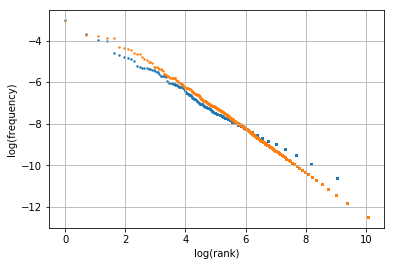

In [104]:
plt.scatter(np.log(ranks1), np.log(freqs1 / np.sum(freqs1)), s=2)
plt.scatter(np.log(ranks2), np.log(freqs2 / np.sum(freqs2)), s=2)
plt.grid(True)
plt.xlabel('log(rank)')
plt.ylabel('log(frequency)');

### Проверим наличие линейной связи с помощью критерия Стьюдента

Для первого корпуса текстов:

Посчитаем коэффициент корреляции Пирсона

In [31]:
rho, pval = st.pearsonr(np.log(ranks1), np.log(freqs1))
rho, pval

(-0.9995860248237144, 0.0)

Посчитаем статистику

In [34]:
n = len(np.log(np.array(freqs1)))
alpha = 0.05
T_test = lambda rho: rho * (n-2)**0.5 / (1 - rho**2)**0.5

In [35]:
T = T_test(rho)
T

-3818.0579213725273

In [45]:
p_value = 2 * st.t.cdf(T, df=n-2)
print('p_value критерия Стьюдента для первого корпуса текстов = {}'.format(p_value))

p_value критерия Стьюдента для первого корпуса текстов = 0.0


Итого, гипотеза о равенстве коэффициента корреляции Пирсона нулю отвергается. То есть между рассмотренными величинами существует линейная связь, причем сильная, исходя из величины самого коэффициента.

Аналогично проверим для второго корпуса текстов:

In [38]:
rho, pval = st.pearsonr(np.log(ranks2), np.log(freqs2))
rho, pval

(-0.999898788545351, 0.0)

In [39]:
n = len(np.log(np.array(freqs2)))
alpha = 0.05
T_test = lambda rho: rho * (n-2)**0.5 / (1 - rho**2)**0.5

In [40]:
T = T_test(rho)
T

-12832.757807607586

In [44]:
p_value = 2 * st.t.cdf(T, df=n-2)
print('p_value критерия Стьюдента для второго корпуса текстов = {}'.format(p_value))

p_value критерия Стьюдента для второго корпуса текстов = 0.0


Аналогично, предыдущему корпусу гипотеза о равенстве коэффициента корреляции Пирсона нулю отвергается.

Найдем MLE оценку на параметр распределения Ципфа $\alpha$:
$$\alpha = 1 + n\sum\limits_{i=1}^n ln(\frac{x_i}{x_{min}}),$$
где $x_i$ - это ранг $i$-го слова в корпусе

Из графика определим $x_{min}$, как минимальный ранг, с которого наблюдается линейная зависимость.

In [54]:
def mle_alpha(ranks, x_min):
    n = len(ranks)
    return 1 + n / np.sum(np.log(ranks / x_min))

Найдем $\alpha$ для первого корпуса

In [115]:
x_min1 = 2
alpha1 = mle_alpha(ranks1, x_min1)
alpha1

1.1186953186136064

In [118]:
def likelyhood(ranks, alpha, x_min):
    const = (alpha - 1) / x_min**(1 - alpha)
    return np.array([const * r**(-alpha) for r in ranks])

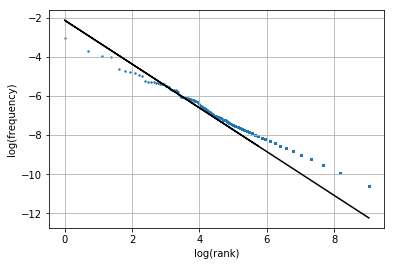

In [117]:
plt.scatter(np.log(ranks1), np.log(freqs1 / np.sum(freqs1)), s=2)
plt.plot(np.log(ranks1), np.log(likelyhood(ranks1, alpha1, x_min1)), color="black")
plt.grid(True)
plt.xlabel('log(rank)')
plt.ylabel('log(frequency)');

Здесь довольно заметно несовпадение прямых, скорее всего это связано с неточным выбором $x_{min}$, так как он выбирался на глаз из графика.

Аналогично проделаем для второго корпуса

In [126]:
x_min2 = 5
alpha2 = mle_alpha(ranks2, x_min2)
alpha2

1.1278436606473123

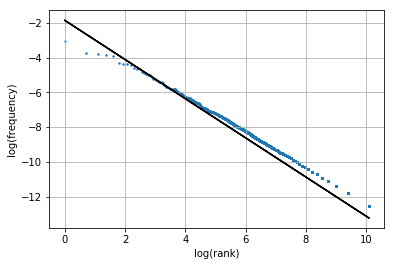

In [95]:
plt.scatter(np.log(ranks2), np.log(freqs2 / np.sum(freqs2)), s=2)
plt.plot(np.log(ranks2), np.log(likelyhood(ranks2, alpha2, x_min2)), color="black")
plt.grid(True)
plt.xlabel('log(rank)')
plt.ylabel('log(frequency)');

Для проверки совпадения параметров распределения Ципфа воспользуемся критерием отношения правдоподобий

In [121]:
def LR_test(alpha0, ranks, x_min):
    alpha_ml = mle_alpha(ranks, x_min)
    return -2 * np.sum((np.log(likelyhood(ranks, alpha0,  x_min)) - np.log(likelyhood(ranks, alpha_ml, x_min))))

In [134]:
alpha0 = 1.12
stat_val = LR_test(alpha0, ranks2, x_min2)
round(stat_val, 2)

130.89

In [135]:
from scipy.stats import chi2
p_val = chi2.sf(stat_val, 1)
p_val

2.617348004895237e-30

Таким образом, была проведена проверка гипотезы о соответствии частот слов распределению Ципфа. По результатам работы можно увидеть, что гипотеза не отклоняется и данные действительно подчиняются этому распределению. А именно, по известным теоретическим фактам для проверки соответствия данных закону Ципфа достаточно проверить линейную зависимость частоты от рангов в лог-масштабе. Методом максимума правдоподобия были найдены оптимальные параметры распределения Ципфа для двух корпусов текстов. Исходя из полученных результатов утверждать о совпадении параметра распределения Ципфа для двух корпусов нельзя ($p\_value$ для критерия отношения правдоподобий $< 0.05$), это объясняется еще тем, что в лог-масштабе $\alpha$ отвечает за коэффициент наклона прямой, а из первого графика можно заметить, что прямые имеют различные углы наклона. 